### Summary

This is the notebook we used for the machine learning model's training, hyperparameter optimization, and scoring. Here we introduce a pipeline for training and tuning the support vector machine model. This module is for demonstration purposes and made for adaptation for other purposes.

### Pipeline

First, we import necessary data analysis packages.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from scipy.stats import sem
import altair as alt
import sys
cur_dir = os.getcwd()
SRC_PATH = cur_dir[
    : cur_dir.index("arm_balance") + len("arm_balance")
]
if SRC_PATH not in sys.path:
    sys.path.append(SRC_PATH)
from src.utils.utils import *

We use `pandas` to load the data.

In [2]:
# Data directory after processing step in 'eda.ipynb'
DATA_DIR = '../../data/grouped_data/grouped_data.csv'
data_frame = pd.read_csv(DATA_DIR,index_col=None)
data_frame.head() # preview the data

,0,1,2,3,4,5,y
0,-0.948985,12.143700,-7.717801,-0.333946,-2.281968,0.157066,12.2181
1,-0.948672,12.143494,-7.718842,-0.334208,-2.281372,0.157082,12.2181
2,-0.948588,12.144102,-7.718846,-0.334369,-2.281600,0.156976,12.2181
3,-0.948620,12.144510,-7.718541,-0.333951,-2.281425,0.157342,12.2181
4,-0.948641,12.142781,-7.718437,-0.335060,-2.281701,0.157264,12.2181


We can see the summary of the data we have.

In our case, we have 180 data points, 6 features (torque values), and 1 target (actual mass). In these 180 data points, we have 18 unique measurements.

In [3]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       180 non-null    float64
 1   1       180 non-null    float64
 2   2       180 non-null    float64
 3   3       180 non-null    float64
 4   4       180 non-null    float64
 5   5       180 non-null    float64
 6   y       180 non-null    float64
dtypes: float64(7)
memory usage: 10.0 KB


In [4]:
data_frame.describe()

,0,1,2,3,4,5,y
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,-0.949581,12.129305,-7.706659,-0.334250,-2.274425,0.157653,9.670889
std,0.002678,0.027602,0.021770,0.001147,0.015369,0.000782,4.841924
min,-0.956857,12.068737,-7.763687,-0.336662,-2.310758,0.156110,0.000000
25%,-0.950866,12.113295,-7.713228,-0.335100,-2.279897,0.157120,6.448500
50%,-0.948818,12.133391,-7.709739,-0.334271,-2.275584,0.157508,10.387350
75%,-0.947593,12.138838,-7.689998,-0.333584,-2.265712,0.158036,10.902900
max,-0.945719,12.193279,-7.661858,-0.331412,-2.242352,0.160079,21.135800


In our case, we have repetitively measured data points whose features are different but the targets are the same. Thus, we do not want to partially train with these data because this might leak information about the training. Thus, we take 150 of the data as the training set and 30 as the test set without shuffling. If your data are all unique measurements, you can shuffle and split the data in this step.

In [5]:
train_df, test_df = train_test_split(data_frame, test_size=30/180, shuffle=False)

Below, we see we have repeated measurements for three objects as "unknown" to the model.

In [6]:
test_df

,0,1,2,3,4,5,y
150,-0.953040,12.138489,-7.713307,-0.334983,-2.278759,0.157573,10.7900
151,-0.953129,12.138799,-7.713703,-0.335020,-2.278590,0.157538,10.7900
152,-0.953454,12.139820,-7.711792,-0.335152,-2.278175,0.157583,10.7900
153,-0.954788,12.137620,-7.713034,-0.335272,-2.278231,0.157485,10.7900
154,-0.952889,12.137985,-7.712506,-0.334753,-2.275564,0.156205,10.7900
155,-0.955176,12.140492,-7.713204,-0.334860,-2.276390,0.157089,10.7900
156,-0.953646,12.140817,-7.712575,-0.334258,-2.275909,0.157316,10.7900
157,-0.952903,12.138852,-7.713300,-0.333041,-2.276392,0.158229,10.7900
158,-0.952978,12.135865,-7.713822,-0.332487,-2.276920,0.159006,10.7900
159,-0.952541,12.133426,-7.714271,-0.333489,-2.278024,0.159058,10.7900


The following code further splits the training set and test set into their respective features and the target.

In [7]:
X_train, y_train = train_df.iloc[:,0:5],train_df['y']
X_test, y_test = test_df.iloc[:,0:5],test_df['y']

We first construct a pipeline to transform the data. Support vector machines (SVM) models are distance-based models, which are sensitive to the scales of the numeric data. We want to bring the features to the same scale using `StandardScaler` from `scikit-learn`. In `scikit-learn` we can use a `Pipeline` to combine the scaling and the model.

In [8]:
pipe_svm = make_pipeline(StandardScaler(), SVR())

Basically, the above is our SVM model. `SVR` is the SVM model used for regression. Here we are going to use the default parameters and in later steps, we can tune the model to better fit the data set.

We can simply fit the model using the code below.

In [9]:
pipe_svm.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR())])

The trained model predicts the following in the test set. 

In [10]:
pipe_svm.predict(X_test)

array([10.20067088, 10.18096334,  9.97238891,  9.55454565,  9.99432601,
        9.45788863,  9.86672025, 10.04928373, 10.00499388, 10.18781146,
       15.00602334, 15.21833766, 15.30143629, 15.31822906, 14.05808316,
       14.13286206, 12.45505711, 13.13170482, 12.86968425, 11.94866228,
        9.03634867,  9.01747195,  8.99551052,  8.95306324,  9.02331043,
        9.14765847,  9.13536833,  8.97290462,  9.05826287,  9.05137961])

We have 3 targets and each of them has 10 votes. We can take the average of these 10 votes to simulate the real-life case if we measure an unknown object and summarize the torques into 10 data points (using 10000 raw data).

In [11]:
print('We have:')
y_test.unique() # these are the three targets

We have:


array([10.79  , 21.1358,  9.0778])

In [12]:
print('We predict they are:')
np.average(pipe_svm.predict(X_test).reshape(3,10), axis=1) # our prediction

We predict they are:


array([ 9.94695927, 13.944008  ,  9.03912787])

Well, it seems not too good if the model. The second prediction is significantly off from other predictions while the first and third are 'OK'.

We can improve the model by hyperparameter tuning! 

In SVM, there are different parameters we can try to tune to make the model works for our data. We will look into two common hyperparameters: `gamma` and `C`.

Without going into a deep understanding of which parameter does what, we can run through a quick scan for a large range of these parameters using `GridSearchCV`. We need to construct a new pipeline to prevent the old results from interfering which the new hyperparameter training.


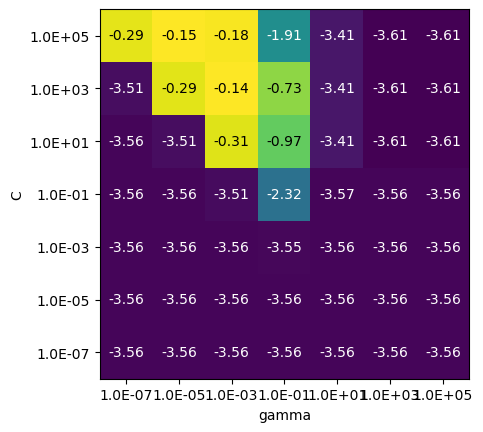

In [13]:
pipe_svm = make_pipeline(StandardScaler(), SVR()) # We can construct a new pipeline
param_grid = {
    "svr__gamma": 10.0**np.arange(-7,7,2),
    "svr__C": 10.0**np.arange(-7,7,2)
}
# function from src/utils/utils.py
model = display_heatmap(param_grid, pipe_svm, X_train, y_train)


We can further zoom into the parts where the negative error is largest. The following code explores from `gamma` = 0 to gamma = 0.00001, and `C` from 10 to 1000000.

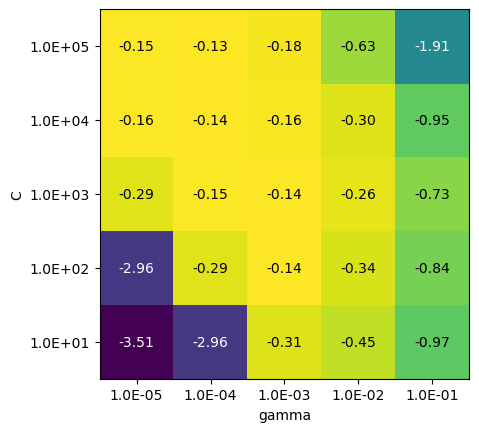

In [14]:
param_grid = {
    "svr__gamma": 10.0**np.arange(-5,0,1),
    "svr__C": 10.0**np.arange(1,6,1),
}
model = display_heatmap(param_grid, pipe_svm, X_train, y_train)

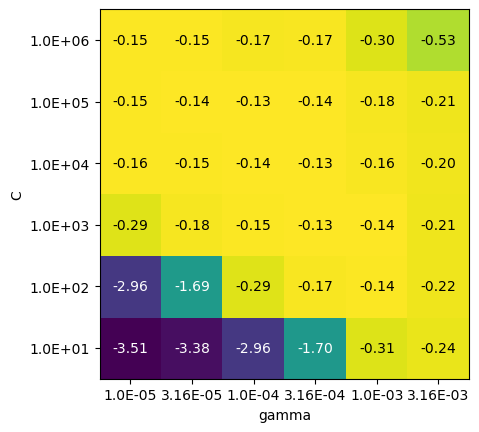

In [15]:
param_grid = {
    "svr__gamma": 10.0**np.arange(-5,-2,0.5),
    "svr__C": 10.0**np.arange(1,7,1),
}
model = display_heatmap(param_grid, pipe_svm, X_train, y_train)

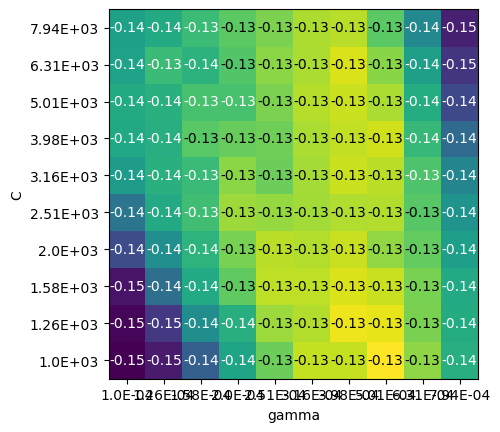

In [31]:
param_grid = {
    "svr__gamma": 10.0**np.arange(-4,-3,0.1),
    "svr__C": 10.0**np.arange(3,4,0.1),
}
model = display_heatmap(param_grid, pipe_svm, X_train, y_train)

We see that we roughly zoomed in on the region with minimal errors. As the model searches through the parameter grid, it also records the best parameters and refits using the training set. We can recheck the performance of the model using the test set.

In [29]:
print('We have:')
y_test.unique() # these are the three targets

We have:


array([10.79  , 21.1358,  9.0778])

In [30]:
print('We predict they are:')
np.average(model.predict(X_test).reshape(3,10), axis=1) # our prediction

We predict they are:


array([10.80613285, 21.34449225,  8.98665578])

We see a huge improvement from the non-tuned model. Notice that we achieve this improvement of accuracy without looking at the test set. This hyperparameter tuning is essentially the degree of freedom that allows `SVR` to better describe the problem than the linear regression model.

In [27]:
model.best_params_

{'svr__C': 1000.000000000002, 'svr__gamma': 0.000501187233627273}